In [1]:

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import root_mean_squared_error
from scipy.optimize import curve_fit

from src.analysis import get_fitting_params
from src.algorithms.lstm import train_and_test_lstm


import os
from src.load_saved_data import (
    load_load_data,
    load_generation_data,
)


In [37]:
from entsoe import EntsoePandasClient
from dotenv import load_dotenv

from src.entsoe_data_imports import (
    get_generation,
    get_wind_solar_forecast,
    get_load_and_forecast,
    get_capacities,
    get_wind_solar_intraday_forecast
)


load_dotenv('api_key.venv')
api_key = os.getenv('ENTSOE_API_KEY')
years = [2022]
# zones = ['NO_2', 'NO_3', 'NO_4', 'DK_1', 'DK_2']
zones = ['ES']
download_data = True


if download_data:
    client = EntsoePandasClient(api_key=api_key)
    get_generation(client, zones, years)  # Get generation data for all carriers for the specified zones and years
    get_wind_solar_forecast(client, zones, years, carriers=['Wind Onshore', 'Solar'])

    # get_wind_solar_intraday_forecast(client, zones, years, carrier='Wind Onshore')

    get_load_and_forecast(client, zones, years)
    get_capacities(client, zones, years, carrier='Wind Onshore')
    get_capacities(client, zones, years, carrier='Solar')
    


In [ ]:
error_type = "wind"
zone = 'NO_2'
years = [2022, 2023, 2024]

In [3]:
years = [2022, 2023, 2024]
# zones = ['NO_2', 'NO_3', 'NO_4', 'DK_1']
zones = ['ES']
error_type = "load"
imbalance = {}

for zone in zones:
    if error_type == "load":
        target_series, forecast_series, scaling_value = load_load_data(years, zone, detrend_flag=False)
    else:
        target_series, forecast_series, scaling_value = load_generation_data(years, zone, carrier=error_type, detrend_flag=False)

    imbalance[zone] = (target_series - forecast_series).abs().mean()
print(imbalance)

{'ES': np.float64(404.35921757714215)}


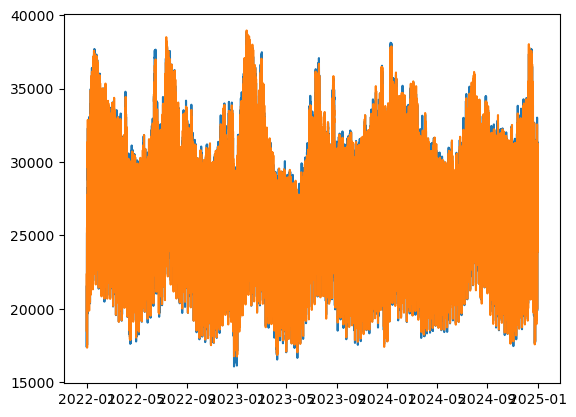

In [4]:
plt.plot(target_series.index, target_series, label='Target Series')
plt.plot(forecast_series.index, forecast_series, label='Forecast Series')

In [ ]:
import pandas as pd
pd.Series(imbalance)

In [ ]:
488. + pd.Series(imbalance).sum()

In [ ]:
962 * 24
# 23 GWh/day

In [14]:
wind_series, wind_forecast_series, capacity = load_generation_data(years, zone, carrier='Solar', detrend_flag=False)

In [15]:
trend = wind_series - target_series
trend

2022-12-31 23:00:00+00:00    2925.656586
2022-12-31 23:15:00+00:00    2925.656586
2022-12-31 23:30:00+00:00    2925.656586
2022-12-31 23:45:00+00:00    2925.656586
2023-01-01 00:00:00+00:00    2449.535618
                                ...     
2024-12-31 21:45:00+00:00    2925.656586
2024-12-31 22:00:00+00:00    2925.656586
2024-12-31 22:15:00+00:00    2925.656586
2024-12-31 22:30:00+00:00    2925.656586
2024-12-31 22:45:00+00:00    2925.656586
Name: Solar, Length: 70169, dtype: float64

In [ ]:



def asymptotic_func(x, a, b):
    return a * x / (x + b)

years = [2023, 2024]
error_type = "Wind Onshore"
zone = 'ES'
if error_type == "load":
    target_series, forecast_series, scaling_value = load_load_data(years, zone, folder="data")
else:
    target_series, forecast_series, scaling_value = load_generation_data(years, zone, carrier=error_type)

    


max_lead_time = 12
for error_type in ["wind"]:
    zones = ['ES']
    # if error_type == "wind":
    #     zones = ['NO_2', 'NO_3', 'NO_4', 'DK_1', 'DK_2']
    # else:
    #     zones = ['NO_1', 'NO_2', 'NO_3', 'NO_4', 'NO_5', 'DK_1']
        # zones = ['NO_2']
    param_df = get_fitting_params(
        error_type, 
        years, 
        zones, 
        train_and_test_function=train_and_test_lstm, 
        fitting_function=asymptotic_func,
        n_lags=3, 
        max_lead_time=max_lead_time,
        data_folder="data"
        )
    param_df.to_csv(f"data/processed/{error_type}_fitting_params_lead_time_{max_lead_time}_{zone}.csv")





In [ ]:
itmin, itmax = 67000, 68000
plt.plot(target_series.index[itmin:itmax], target_series.values[itmin:itmax], label='Detrended Target')
plt.plot(forecast_series.index[itmin:itmax], forecast_series.values[itmin:itmax], label='Detrended Forecast', linestyle='--', linewidth=0.5)


In [ ]:
subset.index

In [ ]:
plt.plot(target_series.loc[subset.index])
plt.plot(forecast_series.loc[subset.index])

In [ ]:
subset

In [ ]:


from src.load_saved_data import (
    load_load_data,
    load_wind_data,
)
from src.algorithms.lstm import train_and_test_lstm


max_lead_time_dict = {
    "wind": 12,
    "load": 12
}
years = [2023, 2024]

n_lags = 3
rmse_per_step = []

zone = 'ES'  # Example zone
rmse_dict = {}
# for error_type in ["wind", "load"]:
for error_type in ["wind"]:
    if error_type == "wind":
        target_series, forecast_series, scaling_value = load_wind_data(years, zone, folder="data")
    else:
        target_series, forecast_series, scaling_value = load_load_data(years, zone, folder="data")

    rmse_per_step = []
    max_lead_time = max_lead_time_dict[error_type]
    for n_lead_time in range(1, max_lead_time + 1):                 
        # y_test, y_pred = train_and_test_random_forest(target_series, forecast_series, n_lags=n_lags, n_lead_time=n_lead_time)
        y_test, y_pred = train_and_test_lstm(target_series, forecast_series, target_series - forecast_series, target_series.index.hour * 60 + target_series.index.minute, n_lags=n_lags, n_lead_time=n_lead_time)
        
        rmse = root_mean_squared_error(y_test, y_pred) / scaling_value
        rmse_per_step.append(rmse)


    rmse_dict[error_type] = rmse_per_step
# Assume rmse_per_step is already defined



In [ ]:
y_pred_dict = {}
y_test_dict = {}
max_lead_time = 4 * 8 
n_lags = 7


years = [2022, 2023, 2024]
# zones = ['NO_2', 'NO_3', 'NO_4', 'DK_1']
zones = ['ES']

rmse_dict = {}
target_series_dict = {}
forecast_series_dict = {}

for error_type in ["Wind Onshore", "Solar", "load"]:
    y_pred_dict[error_type] = {}
    y_test_dict[error_type] = {}

    for zone in zones:
        if error_type == "load":
            target_series, forecast_series, scaling_value = load_load_data(years, zone, detrend_flag=False)
        else:
            target_series, forecast_series, scaling_value = load_generation_data(years, zone, carrier=error_type, detrend_flag=False)

    for n_lead_time in range(1, max_lead_time + 1):                 
        # y_test, y_pred = train_and_test_random_forest(target_series, forecast_series, n_lags=n_lags, n_lead_time=n_lead_time)
        y_test, y_pred = train_and_test_lstm(
            target_series, 
            forecast_series, 
            past_forecast_error=target_series - forecast_series, 
            target_series_hour=target_series.index.hour * 60 + target_series.index.minute, 
            target_series_month=target_series.index.dayofyear,
            n_lags=n_lags, 
            n_lead_time=n_lead_time,
            train_test_split=2/3,
            epochs=20,
            learning_rate=0.001,
            )
        target_series_dict[error_type] = target_series
        forecast_series_dict[error_type] = forecast_series
        y_pred_dict[error_type][n_lead_time] = y_pred
        y_test_dict[error_type][n_lead_time] = y_test

        # rmse = root_mean_squared_error(y_test, y_pred) / scaling_value
        # rmse_dict[error_type][n_lead_time] = rmse




c:\Users\wouterko\GitHub\entsoe-forecasting\src\algorithms\lstm.py:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  future_forecast = forecast[i + n_lags + n_lead_time - 1]  # scalar
c:\Users\wouterko\GitHub\entsoe-forecasting\src\algorithms\lstm.py:18: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  target_value = target[i + n_lags + n_lead_time - 1]       # scalar


Epoch 1/20
1978/1978 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - loss: 0.0930
Epoch 2/20
1978/1978 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.0019
Epoch 3/20
1978/1978 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.0017
Epoch 4/20
1978/1978 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.0016
Epoch 5/20
1978/1978 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.0015
Epoch 6/20
1978/1978 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.0015
Epoch 7/20
1978/1978 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.0015
Epoch 8/20
1978/1978 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.0014
Epoch 9/20
1978/1978 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.0015
Epoch 10/20
1978/1978 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.0014
Epoch 11/20
1978/1978 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.0014
Epoch 12/20
1978/1978 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 0.0014
Epoch 13/20
1978/1978 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.0014
Epoch 14/20
1978/1978 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.0014
Epoch 15/20
1978/1978 ━━━━━━

c:\Users\wouterko\GitHub\entsoe-forecasting\src\algorithms\lstm.py:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  future_forecast = forecast[i + n_lags + n_lead_time - 1]  # scalar
c:\Users\wouterko\GitHub\entsoe-forecasting\src\algorithms\lstm.py:18: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  target_value = target[i + n_lags + n_lead_time - 1]       # scalar


Epoch 1/20
1978/1978 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - loss: 0.0636
Epoch 2/20
1978/1978 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.0047
Epoch 3/20
1978/1978 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.0045
Epoch 4/20
1978/1978 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.0043
Epoch 5/20
1978/1978 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.0043
Epoch 6/20
1978/1978 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.0042
Epoch 7/20
1978/1978 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.0044
Epoch 8/20
1978/1978 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.0043
Epoch 9/20
1978/1978 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 0.0040
Epoch 10/20
1978/1978 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.0042
Epoch 11/20
1978/1978 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.0042
Epoch 12/20
1978/1978 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - loss: 0.0042
Epoch 13/20
1978/1978 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - loss: 0.0041
Epoch 14/20
1978/1978 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.0041
Epoch 15/20
1978/1978 ━━━━━━

c:\Users\wouterko\GitHub\entsoe-forecasting\src\algorithms\lstm.py:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  future_forecast = forecast[i + n_lags + n_lead_time - 1]  # scalar
c:\Users\wouterko\GitHub\entsoe-forecasting\src\algorithms\lstm.py:18: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  target_value = target[i + n_lags + n_lead_time - 1]       # scalar


Epoch 1/20
1977/1977 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 0.0913
Epoch 2/20
1977/1977 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.0079
Epoch 3/20
1977/1977 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.0074
Epoch 4/20
1977/1977 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.0077
Epoch 5/20
1977/1977 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.0073
Epoch 6/20
1977/1977 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.0074
Epoch 7/20
1977/1977 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.0072
Epoch 8/20
1977/1977 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.0071
Epoch 9/20
1977/1977 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.0070
Epoch 10/20
1977/1977 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.0070
Epoch 11/20
1977/1977 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.0072
Epoch 12/20
1977/1977 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.0070
Epoch 13/20
1977/1977 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.0069
Epoch 14/20
1977/1977 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.0069
Epoch 15/20
1977/1977 ━━━━━━━

c:\Users\wouterko\GitHub\entsoe-forecasting\src\algorithms\lstm.py:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  future_forecast = forecast[i + n_lags + n_lead_time - 1]  # scalar
c:\Users\wouterko\GitHub\entsoe-forecasting\src\algorithms\lstm.py:18: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  target_value = target[i + n_lags + n_lead_time - 1]       # scalar


Epoch 1/20
1977/1977 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - loss: 0.0817
Epoch 2/20
1977/1977 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.0111
Epoch 3/20
1977/1977 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.0109
Epoch 4/20
1977/1977 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.0105
Epoch 5/20
1977/1977 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.0103
Epoch 6/20
1977/1977 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.0103
Epoch 7/20
1977/1977 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.0102
Epoch 8/20
1977/1977 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.0103
Epoch 9/20
1977/1977 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.0100
Epoch 10/20
1977/1977 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - loss: 0.0100
Epoch 11/20
1977/1977 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - loss: 0.0101
Epoch 12/20
1977/1977 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - loss: 0.0100
Epoch 13/20
1977/1977 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.0099
Epoch 14/20
1977/1977 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.0096
Epoch 15/20
1977/1977 ━━━━━━━

c:\Users\wouterko\GitHub\entsoe-forecasting\src\algorithms\lstm.py:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  future_forecast = forecast[i + n_lags + n_lead_time - 1]  # scalar
c:\Users\wouterko\GitHub\entsoe-forecasting\src\algorithms\lstm.py:18: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  target_value = target[i + n_lags + n_lead_time - 1]       # scalar


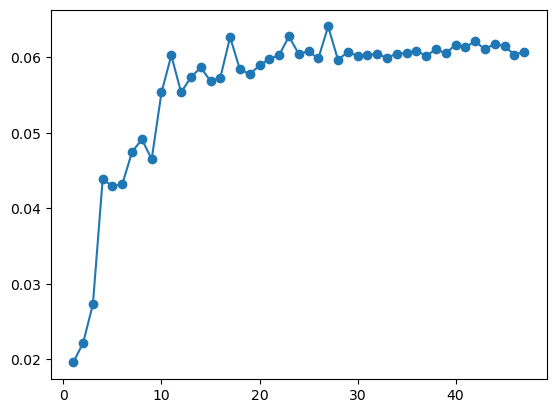

In [31]:
rmse_per_step = {}
for (lead_time, y_pred), (_, y_test) in zip(y_pred_dict.items(), y_test_dict.items()):
    rmse = root_mean_squared_error(y_test, y_pred) / scaling_value
    rmse_per_step[lead_time] = rmse

rmse_ser = pd.Series(rmse_per_step)
plt.plot(rmse_ser.index, rmse_ser.values, marker='o')

32

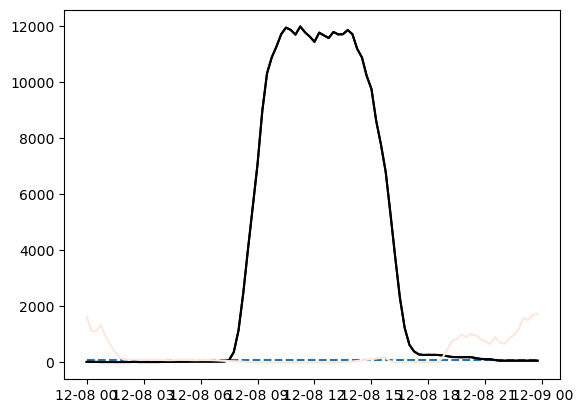

In [17]:
import matplotlib.cm as cm
import numpy as np

start_index = target_series.index.size - y_test.size
tests = target_series.iloc[start_index:]


day = 8
subset = tests.loc[(tests.index.month == 12) & (tests.index.day == day)] 
y_test_ser = pd.Series(y_test, index=tests.index).loc[subset.index]



# Suppose you have max_lead_time
max_lead_time = 35  # Example

# Create a sequential colormap
cmap = plt.get_cmap('Reds')  # You can use others like 'plasma', 'cividis', 'Blues'
plt.plot(forecast_series.loc[subset.index], label='ENTSO-E day-ahead', linestyle='--')
plt.plot(target_series.loc[subset.index], label='Actual', color='black')
# Generate equally spaced color indices
colors = [cmap(i / max_lead_time) for i in range(1, max_lead_time + 1)]
plt.plot(y_test_ser.index, y_test_ser.values, label='Test Data', color='black')
for n_lead_time in range(1, max_lead_time + 1, 4):
    if n_lead_time > 30:
        start_index = target_series.index.size - y_pred_dict[n_lead_time].size
        tests = target_series.iloc[start_index:]

        subset = tests.loc[(tests.index.month == 12) & (tests.index.day == day)] 

        y_pred_ser = pd.Series(y_pred_dict[n_lead_time], index=tests.index).loc[subset.index]

        plt.plot(y_pred_ser.index, y_pred_ser.clip(0).values, label='Predictions', color=colors[max_lead_time-1 - (n_lead_time-1)])

In [19]:
folder = "data/input_entsoe"
carrier = "Solar"
from src.load_saved_data import set_datetime_index

wind_series = pd.concat([
        pd.read_csv(f'{folder}/generation/{zone}/{year}.csv', index_col=0, parse_dates=True, dtype=float)[carrier] 
        for year in years], axis=0)
    
wind_forecast_series =  pd.concat([
    pd.read_csv(f'{folder}/generation_forecasts/{carrier}/{zone}/{year}.csv', index_col=0, parse_dates=True, dtype=float)[carrier] 
    for year in years], axis=0)

wind_series = set_datetime_index(wind_series)
wind_forecast_series = set_datetime_index(wind_forecast_series)

# drop values that are not in both series
wind_series = wind_series[wind_series.index.isin(wind_forecast_series.index)]
wind_forecast_series = wind_forecast_series[wind_forecast_series.index.isin(wind_series.index)]

capacity = pd.read_csv(f'{folder}/mean_capacities/{carrier.replace(' ', '_')}/{zone}.csv', index_col=0).loc[zone].values[0]


<Axes: >

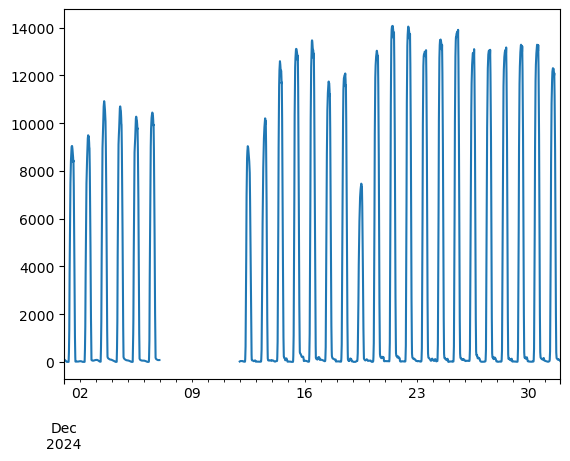

In [29]:
test_set = wind_forecast_series.iloc[start_index:]
test_set.loc[(test_set.index.month == 12)].plot()

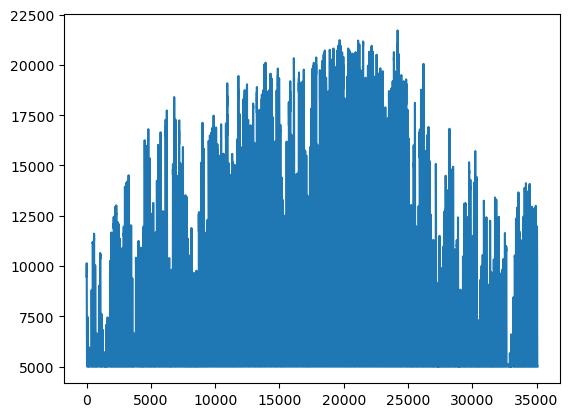

In [23]:
plt.plot(y_pred)

In [14]:
list(range(1, max_lead_time + 1))

[1, 2, 3, 4, 5, 6, 7, 8]

35079

In [ ]:
plt.plot(target_series.loc[subset.index], label='Target Series', color='black')

In [ ]:
y_pred_ser.index.minute

In [ ]:
y_pred.size

In [ ]:
y_test.size

In [ ]:
356*2*24

In [ ]:
scaling_value

In [19]:
def asymptotic_func(x, a, b):
    return a * x / (x + b)

plt.figure(figsize=(6, 4))

error_colors = {
    "wind": "tab:green",  
    "load": "darkred",  
}

for error_type, rmse_per_step in rmse_dict.items():
    horizons = np.arange(1, len(rmse_per_step) + 1)
    error_type_nice_name = "Wind" if error_type == "wind" else "Load"
    horizons = np.arange(1, max_lead_time_dict[error_type] + 1)
    # Ensure rmse_per_step is a numpy array
    rmse_per_step = np.array(rmse_per_step)
    plotting_linspace = np.linspace(0, 12, 100)
    # Fit the function to the data

    asymptotic_params, _ = curve_fit(asymptotic_func, horizons, rmse_per_step)
    asymptotic_fitted_rmse = asymptotic_func(plotting_linspace, *asymptotic_params)

    plt.scatter(horizons, 100 * rmse_per_step, color=error_colors[error_type], marker='x', label=f'{error_type_nice_name}', s=100)
    plt.plot(plotting_linspace, 100 * asymptotic_fitted_rmse, linestyle='--', color=error_colors[error_type], label=rf'Fit {error_type}')

plt.xlabel("Lead time [h]")
plt.xticks([0, 3, 6, 9, 12])

plt.ylabel("NRMSE [%]")
plt.grid(True)
plt.legend(bbox_to_anchor=(0., 1.02), loc='lower left', borderaxespad=0., ncols=2)
plt.tight_layout()
plt.xlim((0, 12))
# plt.savefig(f'plots/nrmse_lag_{n_lags}_{zone}_top_legend.pdf', bbox_inches='tight')
plt.show()

NameError: name 'rmse_dict' is not defined

<Figure size 600x400 with 0 Axes>

In [ ]:
asymptotic_params

In [ ]:
from src.plotting.plotting_config import set_plt_settings

def asymptotic_func(x, a, b):
    return a * x / (x + b)

set_plt_settings()

rmse_per_step = pd.read_csv("data/processed/rmse_per_step_example.csv", index_col=0)

label_size = 24

fig, ax = plt.subplots(figsize=(6, 4))

error_colors = {
    "wind": "tab:green",  
    "load": "darkred",  
}
max_lead_time_dict = {
    "wind": 12,
}
error_type = "wind"
# rmse_per_step = rmse_dict["wind"]
horizons = np.arange(1, len(rmse_per_step) + 1)
error_type_nice_name = "Wind" if error_type == "wind" else "Load"
horizons = np.arange(1, max_lead_time_dict[error_type] + 1)
# Ensure rmse_per_step is a numpy array
rmse_per_step = np.array(rmse_per_step)[:, 0]
plotting_linspace = np.linspace(0, 12, 100)
# Fit the function to the data

asymptotic_params, _ = curve_fit(asymptotic_func, horizons, rmse_per_step)
asymptotic_fitted_rmse = asymptotic_func(plotting_linspace, *asymptotic_params)

plt.scatter(horizons, 100 * rmse_per_step, color=error_colors[error_type], marker='x', label=f'{error_type_nice_name}', s=100, linewidth=2)
plt.plot(plotting_linspace, 100 * asymptotic_fitted_rmse, linestyle='--', color=error_colors[error_type], label=rf'Fit {error_type}', linewidth=2)

plt.xlabel("Lead time [h]", fontsize=label_size)
# plt.xticks([0, 3, 6, 9, 12])

plt.ylabel("NRMSE [%]", fontsize=label_size)
plt.grid(False)
ax.set_xticks([], [])
ax.set_yticks([], [])
plt.yticks(None, None)

# turn off right spines and top spines
for spine in ['top', 'right']:
    ax.spines[spine].set_visible(False)

# plt.legend(bbox_to_anchor=(0., 1.02), loc='lower left', borderaxespad=0., ncols=2)
plt.tight_layout()
plt.xlim((0, 12))
plt.ylim((0, 9))
plt.savefig('plots/sketch_nrmse.pdf', bbox_inches='tight')
plt.show()

In [ ]:
rmse_per_step = pd.read_csv("data/processed/rmse_per_step_example.csv", index_col=0)

In [ ]:
# pd.Series(rmse_per_step, index=horizons).to_csv("data/processed/rmse_per_step_example.csv")

In [ ]:
rmse_per_step.values